In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [3]:
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the InceptionV3 model (excluding the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model
model = keras.Sequential()

# Add the pre-trained InceptionV3 model
model.add(base_model)

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(38, activation='softmax'))

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the model
checkpoint_filepath = 'model_checkpoint_inceptionv3.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',  # You can choose the metric to monitor, e.g., validation accuracy
    mode='max',
    save_best_only=True
)

# Train the model with the ModelCheckpoint callback
history = model.fit(train_gen, epochs=10, validation_data=test_gen, callbacks=[model_checkpoint_callback])


87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/10
2197/2197 [==============================] - 238s 103ms/step - loss: 1.0436 - accuracy: 0.7092 - val_loss: 0.3609 - val_accuracy: 0.8853
Epoch 2/10
2197/2197 [==============================] - 225s 102ms/step - loss: 0.5172 - accuracy: 0.8416 - val_loss: 0.2792 - val_accuracy: 0.9141
Epoch 3/10
2197/2197 [==============================] - 225s 102ms/step - loss: 0.3998 - accuracy: 0.8781 - val_loss: 0.2131 - val_accuracy: 0.9330
Epoch 4/10
2197/2197 [==============================] - 215s 98ms/step - loss: 0.3249 - accuracy: 0.8998 - val_loss: 0.2199 - val_accuracy: 0.9316
Epoch 5/10
2197/2197 [==============================] - 224s 102ms/step - loss: 0.2740 - accuracy: 0.9162 - val_loss: 0.1994 - val_accuracy: 0.9378
Epoch 6/10
2197/2197 [==============================] - 224s 102ms/step - loss: 0.2488 - accuracy: 0.9241 - val_loss: 0.1882 - val_accuracy: 0.9412
Epoch 7/10
2197/2197 [==========================

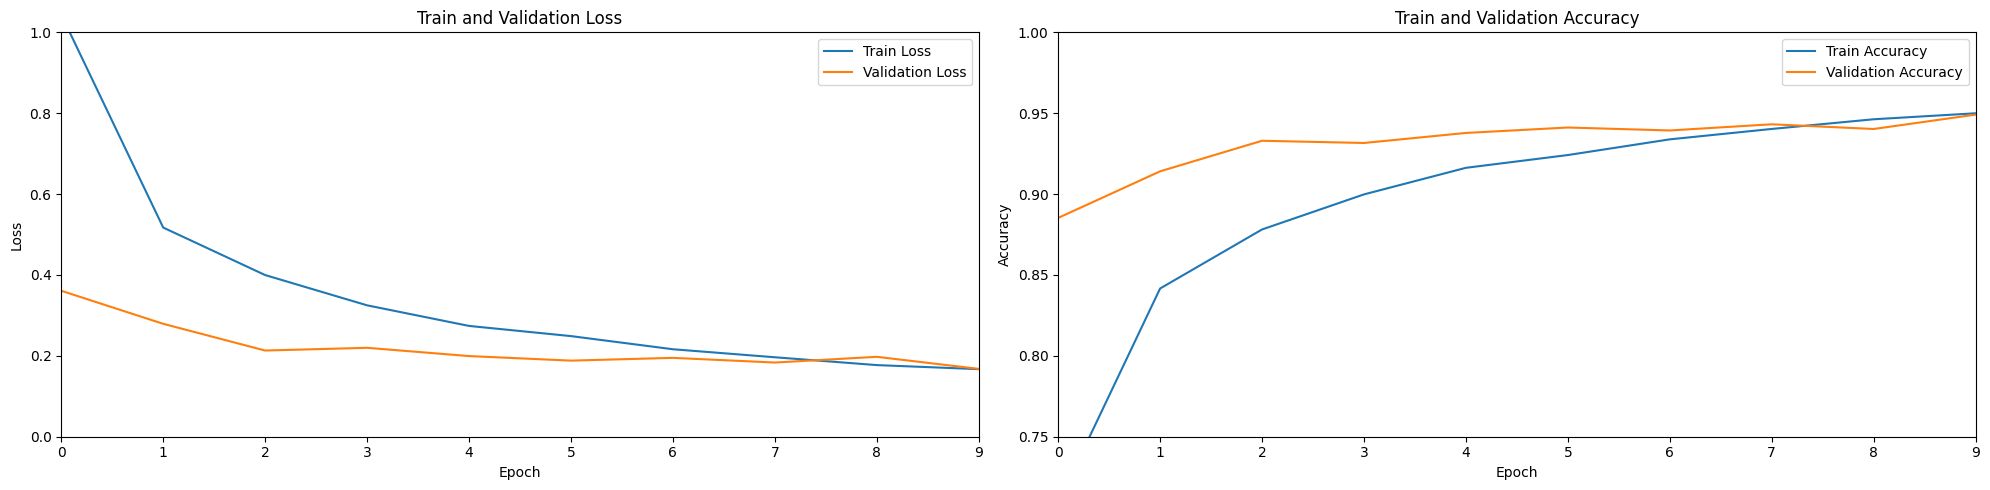

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 9)  # Adjusted xlim to match the number of epochs
plt.ylim(0.0, 1.0)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9)  # Adjusted xlim to match the number of epochs
plt.ylim(0.75, 1.0)
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

1/1 [==============================] - 1s 1s/step


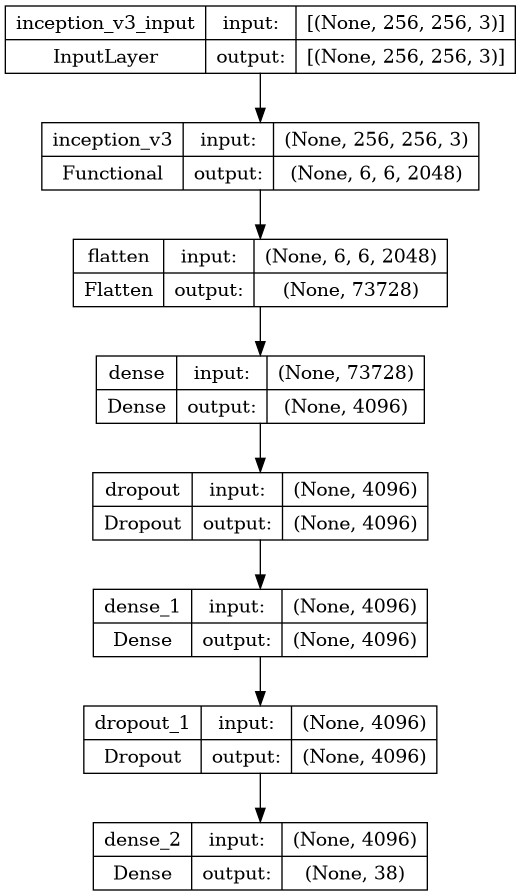

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load your trained model from the .h5 file
model = load_model('/kaggle/working/model_checkpoint_inceptionv3.h5', compile=False)  # Set compile to False

# Plot the architecture of the model and save it as an image file (e.g., PNG)
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [7]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [8]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Assuming you have the actual values in 'actual_labels' and predictions in 'predictions'

mse = mean_squared_error(labels, predictions)
rmse = mean_squared_error(labels, predictions, squared=False)

print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1] * 100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))
print("Mean Squared Error: {:.2f}".format(mse))
print("Root Mean Squared Error: {:.2f}".format(rmse))


Train Accuracy  : 95.00 %
Test Accuracy   : 94.91 %
Precision Score : 94.91 %
Recall Score    : 94.91 %
Mean Squared Error: 2.63
Root Mean Squared Error: 1.62


<Figure size 2000x500 with 0 Axes>

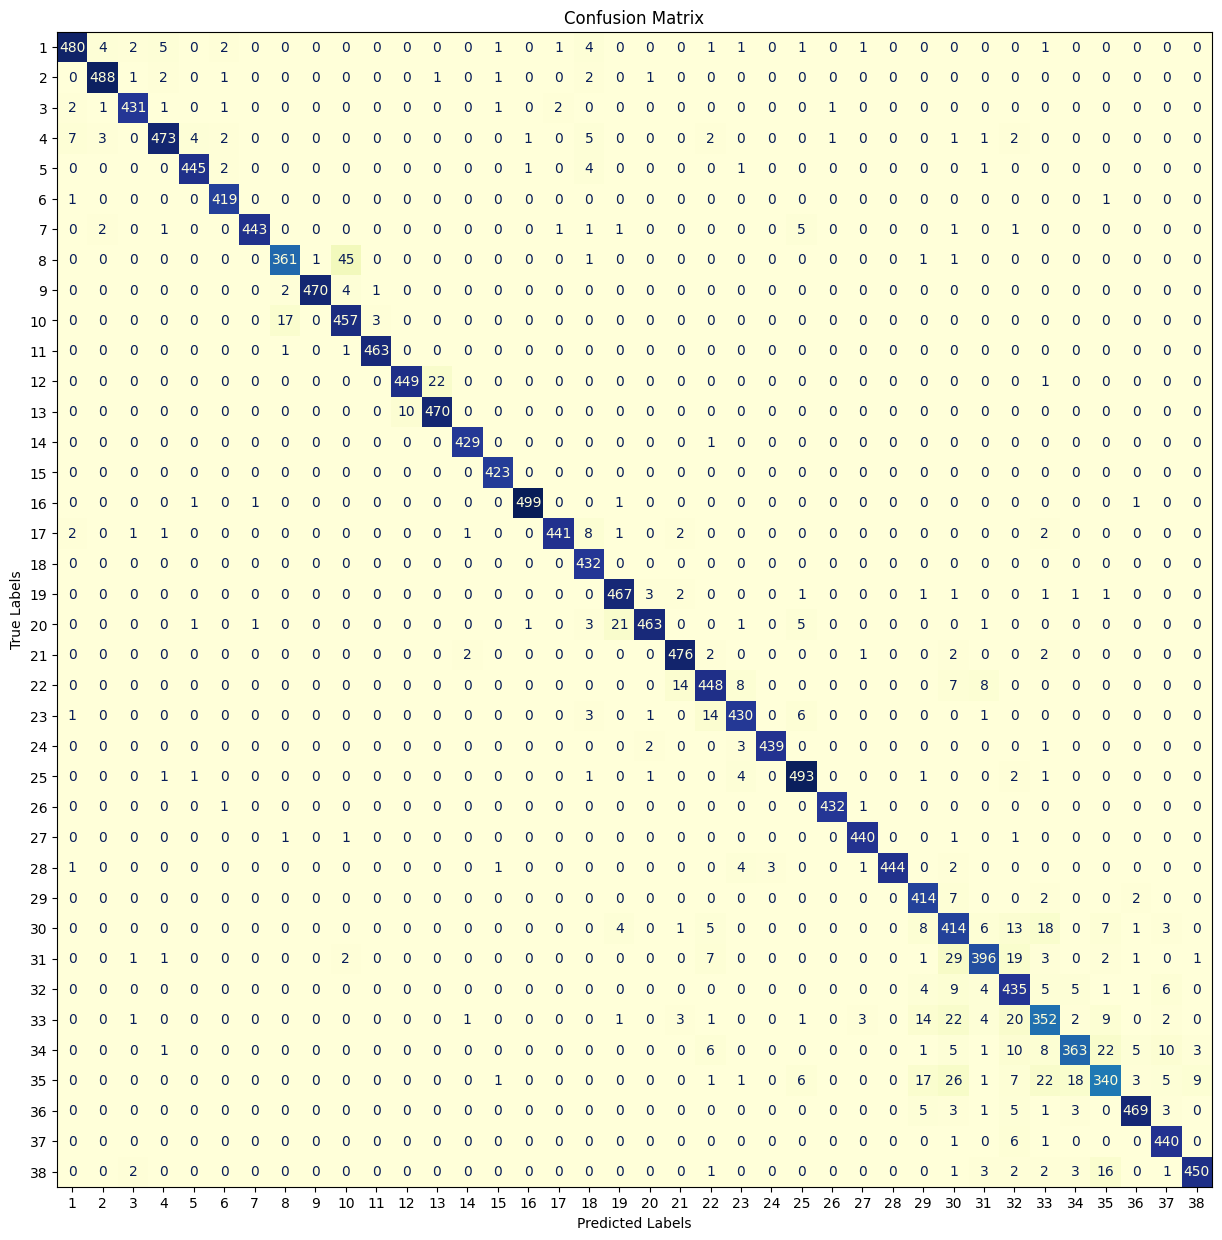

In [9]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load your trained model from the .h5 file
model = load_model("/kaggle/working/model_checkpoint_inceptionv3.h5", compile=False)  # Set compile to False

# Plot the architecture of the model and save it as an image file (e.g., PNG)
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
